In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import io
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from preprocessing import parse_aug_fn, parse_fn

In [3]:
y_true = [2, 1, 0, 2, 2, 0, 1, 1]
y_pred = [0, 1, 0, 2, 2, 0, 2, 1]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
print(cm)

[[2 0 0]
 [0 2 1]
 [1 0 2]]


In [4]:
def plot_confusion_matrix(cm, class_names):
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_index = np.arange(len(class_names))
    plt.yticks(tick_index, class_names)
    plt.xticks(tick_index, class_names, rotation=45)
    plt.colorbar()
    
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > threshold else 'black'
            plt.text(j, i, cm[i, j], horizontalalignment='center', color=color)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return figure

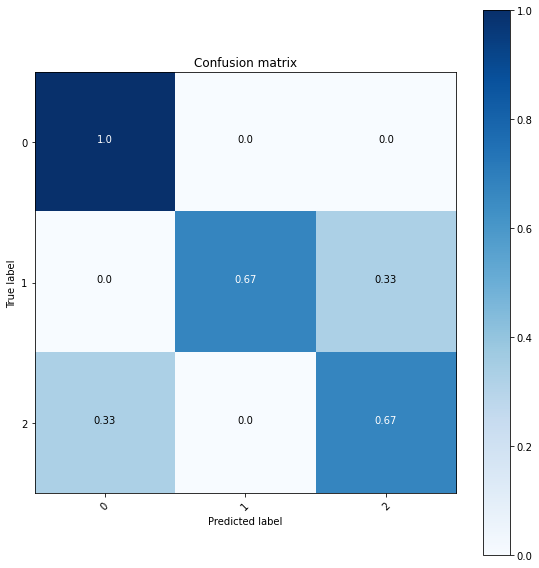

In [8]:
img = plot_confusion_matrix(cm, [0, 1, 2])

In [9]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

In [ ]:
class ConfusionMatrix(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, test_data, class_name):
        super(ConfusionMatrix, self).__init__()
        self.log_dir = log_dir
        self.test_data = test_data
        self.class_names = class_name
        self.num_classes = len(class_name)
    
    def on_train_begin(self, logs=None):
        path = os.path.join(self.log_dir, 'confusion_matrix')
        self.writer = tf.summary.create_file_writer(path)
    
    def on_epoch_end(self, epoch, logs=None):
        total_cm = np.zeros([10, 10])
        for x, y_true in self.test_data:
            y_pred = self.model.predict(x)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
            total_cm += cm
        figure = plot_confusion_matrix(total_cm, class_names=self.class_names)
        cm_image = plot_to_image(figure)
        
        with self.writer.as_default():
            tf.summary.image('Confusion Matrix', cm_image, step=epoch)